# COGS 108 - Final Project 
## Name & PID

- Dayyan Sisson
- A13385926

# Overview
In this project, I analyzed the relationship between ethnic diversity in a locality and critical health inspection statistics in cities in North Carolina. I used the provided data and public census data to build data sets containing information on restaurant's cuisines, health inspection records, and the diversity data on its surrounding locality. After analysis, I concluded that there was no significant relationship between ethnic diversity in a locality and critical health inspection statistics in cities in North Carolina.

# Research Question
In North Carolina cities, what is the relationship between the level of ethnic diversity in a locality (small geographic unit, like zipcode or town), and critical health inspection statistics (violation count, health score) in that locality?

## Background and Prior Work
There has been research done on race, age, class based disparities in levels of inspections carried out by the EPA, which has led some research to suggest that measures must be taken to improve the equity of the inspection process (1). This research was conducted looking at, in a community, the percentage of African Americans, percentage of Hispanics, low SES index, amongst other variables. 

Additionally, research has shown that "Food safety compliance amongst ethnic minority food retail businesses has been identified as being less than satisfactory", and that "the research recognizes that language difficulties and lack of knowledge and understanding of the principles of food safety are a major barrier to promoting food safety" (2).

**References (include links):**
- 1. https://onlinelibrary.wiley.com/doi/abs/10.1111/ssqu.12160
- 2. https://www.sciencedirect.com/science/article/abs/pii/S0956713504002324

# Hypothesis
My hypothesis, is that health ratings in localities with more ethnic diversity than will be lower than those with less ethnic diversity.

I believe that barriers in language, lower levels of food safety education, and challenges related to the equity in which health inspections are carried out result in lower food safety ratings in ethnically diverse communities. Communities with less diversity (even if the population is largely composed of American racial minorities) will have, in general, higher food safety ratings, since equitable inspections can be carried out more easily amongst a singular target population.

# Dataset(s)

### yelp
- **Link:** (provided)
- **Num. Observations:** 3688
- **Description:** Contains yelp data on restaurants around North Carolina, including name, yelp rating, address, and type of cuisine.

### violations
- **Link:** (provided)
- **Num. Observations:** 189802
- **Description:** Contains data on health code violations recorded on restaurants in North Carolina.

### restaurants
- **Link:** (provided)
- **Num. Observations:** 3324
- **Description:** Contains data restaurants around North Carolina, including important identifying information such as hsisid, postal code, and phone number.

### inspections
- **Link:** (provided)
- **Num. Observations:** 18466
- **Description:** Contains health inspection data on restaurants in North Carolina. Critically, it contains data on health scores given to particular hsisids.

### uszips
- **Link:** https://simplemaps.com/data/us-zips
- **Num. Observations:** 33099
- **Description:** Contains data on valid US zip codes, and the city they belong to.

### census_nc_demo (1-3)
- **Link:** https://www.census.gov/quickfacts/
- **Num. Observations:** 249
- **Description:** Contains demographic census data on counties and cities corresponding to relevant zip codes in North Carolina. Collected by identifying relevant zip codes and pulling census demographic data on their associated city. Split into 3 files.

## Combining Datasets
- The yelp, violations, restaurants, and inspections data sets will all be combined together to form the `df_bycuisine` data set, which uses the yelp data set to associate a cuisine with restaurants, and their associated inspections and violations data.
- The census_nc_demo and zip codes data sets will all be combined together to form the `df_census` data set, which will be used to associate zipcodes with census data on their corresponding demographics. An additional column `diversity index` will be generated from the data by using the Simpson Diversity Index to quantify diversity in a locality. Visit this link to learn more about the Simpson Diversity Index: https://www.statisticshowto.com/simpsons-diversity-index/
- The violations, inspections, and `df_census`data sets will all be combined together to form the `df_bylocality` and `df_byrestaurant` data sets, which associates a diversity index to restaurants, grouped by locality or left individually, respectively.

More specific details on how aggregations will be carried out is included in the _Data Cleaning_ section.

# Setup

All the code setup, including importing libraries (such as `numpy`, `pandas`, `seaborn`, `matplotlib`, etc...) and setting default parameters.

## Import Libraries

In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('lines', linewidth=2, color='r')

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

# Data Cleaning

Loading and cleaning the `yelp`, `restaurants`, `inspections`, and `violations` data sets. This includes loading the data, dropping unnecessary columns, making column names more concise, and dropping rows with critical data missing. Once the datasets are cleaned they will be merged. Step one will be to merge the `violations`, `restaurants`, and `inspections` data by `hsisid`. The `yelp` data set will then be merged with the resultant dataset by  matching `phone number`, `latitude`, and `longtitude`.

### Standardization Functions
Since some of the data will need to be standardized, these functions will be defined here.

- `standardize_zip` will standardize zip codes into an `xxxxx` format (i.e. `27560`).
- `standardize_phone` will standardize phone numbers into an `xxxxxxxxxx` format (i.e. `2102230500`).

### Misc. Functions
Many more functions are defined below to assist with the data cleaning process. Descriptions are provided as header comments.

In [2]:
# Checks to see if a string contains letters by uppercasing the string then checking to see if there 
# are any uppercase letters
def contains_letters(string):
    
    return string.upper().isupper()

In [3]:
# Returns the zipcode in 5 digit format

# Takes in str/int object, converts it to a string, returns zipcode as 5-digit long int
# Note: if zipcode is less than 5 digits long, or contains any letters returns None (NaN)

def standardize_zip(zipcode):
    
    string = str(zipcode)
    if len(string) < 5 or contains_letters(string):
        return None
    elif len(string) is 5:
        return int(string)
    
    return int(string[0:5])

In [4]:
# Returns the phone number in xxxxxxxxxx

# Takes in str/int object, converts it to a string, returns as formatted string.
# Note: if phone number is invalid, returns None.

def standardize_phone(phone):
    
    string = str(phone)
    string.strip()
    if contains_letters(string):
        return None
    
    # Remove all extra characters anticipated
    string = string.replace('-', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace(' ', '')
    string.strip()
    
    # If phone number is invalid, return None
    if len(string) < 10:
        return None
    
    # Remove international code
    if len(string) > 10:
        string = string[1:]
    
    return string

In [5]:
# Returns cuisine type

# Takes in a row from a dataframe, and checks if any of the cuisine-related values are marked as true. Returns
# string representation of that cuisine
# Note: if all cuisine-related entries are false, returns None.

def extract_cuisine(row):
    
    if(row['hotdogs']):
        return 'american'
    elif(row['sandwiches']):
        return 'american'
    elif(row['pizza']):
        return 'american'
    elif(row['tradamerican']):
        return 'american'
    elif(row['burgers']):
        return 'american'
    elif(row['mexican']):
        return 'mexican'
    elif(row['grocery']):
        return 'other'
    elif(row['breakfast_brunch']):
        return 'american'
    elif(row['coffee']):
        return 'american'
    elif(row['chinese']):
        return 'chinese'
    elif(row['italian']):
        return 'italian'
    elif(row['newamerican']):
        return 'american'
    elif(row['chicken_wings']):
        return 'american'
    elif(row['delis']):
        return 'american'
    elif(row['bars']):
        return 'other'
    elif(row['salad']):
        return 'american'
    elif(row['seafood']):
        return 'other'
    elif(row['bbq']):
        return 'american'
    elif(row['bakeries']):
        return 'other'
    elif(row['sushi']):
        return 'japanese'
    
    return None

In [6]:
# Returns whether or not a cuisine is labelled as "ethnic"

# Takes in a row from a dataframe, and checks if cuisine is mexican, chinese, italian, or sushi. Returns
# true if any of these are true, otherwise false.

def is_ethnic(row):
    
    cuisine = row['cuisine']
    if(cuisine is 'mexican' or cuisine is 'chinese' or cuisine is 'italian' or cuisine is 'japanese'):
        return True
    
    return False

In [7]:
# Transform census data frames to have demographic info as columns and actual data in the rows

def prep_census_df(df_raw):

    # Transpose dataframe and set appopriate headers
    df_raw = df_raw.transpose()
    df_raw.columns = df_raw.iloc[0]
    df_raw.drop(df_raw.index[0], inplace=True)


    # Drop unnecessary columns
    df_raw.rename(columns={'White alone, not Hispanic or Latino, percent':'white %',
                       'Black or African American alone, percent':'black %',
                       'American Indian and Alaska Native alone, percent':'native american %',
                       'Asian alone, percent':'asian %',
                       'Native Hawaiian and Other Pacific Islander alone, percent':'pacific islander %',
                       'Two or More Races, percent':'mixed %',
                       'Hispanic or Latino, percent':'hispanic or latino %',
                     }, inplace=True)
    df_raw = df_raw[['white %', 'black %','hispanic or latino %','asian %',
             'native american %','pacific islander %', 'mixed %']]
    
    return df_raw

In [8]:
# Matches a city with a zip code

def match_zip(city):
    
    cities = df_zipdata[(df_zipdata['city'] == city)]
    if len(cities) is 0:
        return None
    
    return list(cities['zip'])

In [9]:
# Matches a zip code with its diversity index

def match_zip_div(zipcode):
    
    values = None
    for i in range(len(df_census)):
        if zipcode in df_census.iloc[i]['zip']:
            values = df_census.iloc[i]

    if values is None or len(values) is 0:
        return None
    
    return values['diversity index'].mean()

In [10]:
# Matches a zip code with an average of its average health scores

def match_zip_avghs(row):
    
    values = df[df['zip'].isin(row['zip'])]
    if len(values) is 0:
        return None
    
    return values['avg. health score'].mean()

In [11]:
# Matches a zip code with an average of its violation count

def match_zip_avgvc(row):
    
    values = df[df['zip'].isin(row['zip'])]
    if len(values) is 0:
        return None
    
    return values['avg. violation count'].mean()

In [12]:
# Converts str percent to float
def p2f(x):
    return float(x.strip('%'))/100

# Calculates simpson index corresponding to a row
def calc_simpson_index(row):
    
    white = p2f(row['white %'])**2
    black = p2f(row['black %'])**2
    hisp_lat = p2f(row['hispanic or latino %'])**2
    asian = p2f(row['asian %'])**2
    nat_amer = p2f(row['native american %'])**2
    pac_isl = p2f(row['pacific islander %'])**2
    mixed = p2f(row['mixed %'])**2
    
    return 1/(white + black + hisp_lat + asian + nat_amer + pac_isl + mixed)

### Load & Clean Yelp Data
The `yelp.csv` is already in TidyData format. To clean the dataframe, we need to drop unnecessary columns, and make column names more concise. Also, since we will be merging this data set with the others by matching `phone number`, `latitude`, and `longtitude`, we will drop any rows if any of that information is missing. Last we need to standardize the data and extract the cuisine name for each entry.

In [13]:
# Load data
df_yelp = pd.read_csv('Data/yelp.csv')
print('Yelp Data\n---')
print('Before Clean: ', df_yelp.shape)

# Drop unnecessary columns
df_yelp.drop(columns=['id', 'price', 'address1', 'latitude', 'longitude', 'is_closed', 'review_count'], inplace=True)

# Rename columns
df_yelp.rename(columns={'zip_code':'zip', 'rating':'yelp rating'}, inplace=True)

# Standardize df
df_yelp['zip'] = df_yelp['zip'].apply(standardize_zip)
df_yelp['phone'] = df_yelp['phone'].apply(standardize_phone)

# Drop rows with critical data missing
df_yelp.dropna(subset=['phone', 'zip'], inplace=True)

# Remove cuisine booleans with one column that contains string identifier
df_yelp['cuisine'] = df_yelp.apply(extract_cuisine, axis=1)
df_yelp.drop(columns=['hotdogs','sandwiches','pizza','tradamerican','burgers','mexican',
                      'grocery','breakfast_brunch','coffee','chinese','italian','newamerican',
                      'chicken_wings','delis','bars','salad','seafood','bbq','bakeries','sushi'], inplace=True)

# Add column identifying if cuisine is ethnic
df_yelp['ethnic'] = df_yelp.apply(is_ethnic, axis=1)

# Reset index and show first 5 rows
df_yelp.reset_index(drop=True, inplace=True)
print('After Clean: ', df_yelp.shape)

Yelp Data
---
Before Clean:  (3688, 31)
After Clean:  (3648, 6)


### Load & Clean Restaurants Data
The `restaurants.csv` is already in TidyData format. This dataframe will be used mostly for linking the yelp data set with the other data sets, since this data set contains an hsisid, phone number, and coordinates to match between all the sets.

To clean the dataframe, we need to drop unnecessary columns, and make column names more concise. We need to standardize the data and reformat specific columns. Last we will drop any rows if any information is missing.

In [14]:
# Load data
df_restaurants = pd.read_csv('Data/restaurants.csv')
print('Restaurants Data\n---')
print('Before Clean: ', df_restaurants.shape)

# Grab necessary columns
df_restaurants = df_restaurants[['hsisid', 'phonenumber']]

# Rename columns
df_restaurants.rename(columns={'phonenumber':'phone'}, inplace=True)

# Standardize df
df_restaurants['phone'] = df_restaurants['phone'].apply(standardize_phone)

# Drop rows with critical data missing
df_restaurants.dropna(inplace=True)

# Reset index and show first 5 rows
df_restaurants.reset_index(drop=True, inplace=True)
print('After Clean: ', df_restaurants.shape)
df_restaurants.head()

Restaurants Data
---
Before Clean:  (3324, 14)
After Clean:  (3127, 2)


,hsisid,phone
0,4092017230,9199773679
1,4092014444,9195544924
2,4092015333,9198353553
3,4092110477,9192504756
4,4092016679,9199773829


### Load & Clean Inspections Data
The `inspections.csv` is already in TidyData format. From this data set, we want the `hsisid` and its health score. Since a restaurant may have several health scores associated with it, we will take the mean of the scores, and drop any rows with null values.

In [15]:
# Load data
df_inspections = pd.read_csv('Data/inspections.csv')
print('Inspections Data\n---')
print('Before Clean: ', df_inspections.shape)

# Drop unnecessary columns
df_inspections = df_inspections[['hsisid', 'score', 'zip']]
df_inspections.rename(columns={'score':'avg. health score'}, inplace=True)

# Average scores together
df_inspections = df_inspections.groupby('hsisid').mean()

# Clean data frame
df_inspections.reset_index(inplace=True)
df_inspections.dropna(inplace=True)

# Show first 5 rows
print('After Clean: ', df_inspections.shape)
df_inspections.head()

Inspections Data
---
Before Clean:  (18466, 36)
After Clean:  (3045, 3)


,hsisid,avg. health score,zip
0,4092010018,94.333333,27628
1,4092010024,94.772727,27607
2,4092010031,94.375000,27604
3,4092010035,94.500000,27511
4,4092010037,96.400000,27591


### Load & Clean Violations Data
The `violations.csv` is already in TidyData format. The data we need from this dataframe is the amount of violations corresponding to a particular id

In [16]:
# Load data
df_violations = pd.read_csv('Data/violations.csv')
print('Violations Data\n---')
print('Before Clean: ', df_violations.shape)

# Generate violation count data
df_violations = df_violations.groupby('hsisid',as_index=False).size()
df_violations = df_violations.to_frame()

# Clean data frame
df_violations.reset_index(inplace=True)
df_violations.rename(columns={0:'violation count'}, inplace=True)
df_violations.dropna(inplace=True)

# Show first 5 rows
print('After Clean: ', df_violations.shape)
df_violations.head()

Violations Data
---
Before Clean:  (189802, 18)
After Clean:  (4270, 2)


,hsisid,violation count
0,4092010018,93
1,4092010024,92
2,4092010031,20
3,4092010035,44
4,4092010037,43


### Load & Clean Census & Zipcode Data
The `census_nc_demo1.csv`, `census_nc_demo2.csv`, `census_nc_demo3.csv` files are already in TidyData format. We need to combine them into one larger census data set, and then associate the cities in it with their corresponding zipcodes so we can merge this data set with the other data sets later. Finally we'll calculate the Simpson Diversity Index for each locality.

In [17]:
# Load & transpose census data
df_census1 = prep_census_df(pd.read_csv('Data/census_nc_demo1.csv'))
df_census2 = prep_census_df(pd.read_csv('Data/census_nc_demo2.csv'))
df_census3 = prep_census_df(pd.read_csv('Data/census_nc_demo3.csv'))

# Append dataframes
df_census = df_census1.append(df_census2).append(df_census3)

# Transpose back for cleaning
df_census = df_census.transpose()

# Drop unnecessary columns
df_census.rename(columns={ 'Fuquay-Varina town, North Carolina':'fuquay varina',
                           'Butner town, North Carolina':'butner',
                           'Clayton town, North Carolina':'clayton',
                           'Cary town, North Carolina':'cary',
                           'Apex town, North Carolina':'apex',
                           'Angier town, North Carolina':'angier',
                           'Roxboro city, North Carolina':'roxboro',
                           'Rolesville town, North Carolina':'rolesville',
                           'Morrisville town, North Carolina':'morrisville',
                           'Knightdale town, North Carolina':'knightdale',
                           'Holly Springs town, North Carolina':'holly springs',
                           'Garner town, North Carolina':'garner',
                           'Durham city, North Carolina':'durham',
                           'Raleigh city, North Carolina':'raleigh',
                           'Zebulon town, North Carolina':'zebulon',
                           'Wendell town, North Carolina':'wendell',
                           'Wake Forest town, North Carolina':'wake forest',
                         }, inplace=True)

df_census = df_census[[ 'fuquay varina','butner','clayton','cary','apex',
                        'angier','roxboro','rolesville','morrisville',
                        'knightdale','holly springs','garner','durham',
                        'raleigh','zebulon','wendell','wake forest']]

# Transpose back and set index
df_census.rename_axis('', axis='rows', inplace=True)
df_census = df_census.transpose().reset_index()
df_census.rename(columns={'index': 'locality'}, inplace=True)

# Calculate Simpson Diversity Index
df_census['diversity index'] = df_census.apply(calc_simpson_index, axis='columns')

# Load zip data
df_zipdata = pd.read_csv('Data/uszips.csv')

# Grab only necessary columns
df_zipdata = df_zipdata[['zip', 'city']]

# Convert 'city' data to lowercase
df_zipdata['city'] = df_zipdata['city'].apply(lambda x: x.lower())

# Restrict to NC zipcodes
df_zipdata = df_zipdata[df_zipdata['zip'] >= 27000]
df_zipdata = df_zipdata[df_zipdata['zip'] <= 29000]

# Convert localities to zipcodes
df_census['zip'] = df_census['locality'].apply(match_zip)
df_census.head()

,locality,white %,black %,hispanic or latino %,asian %,native american %,pacific islander %,mixed %,diversity index,zip
0,fuquay varina,70.7%,14.1%,11.1%,1.4%,0.2%,0.0%,3.4%,1.874741,[27526]
1,butner,49.8%,29.4%,15.6%,1.8%,0.3%,0.0%,3.9%,2.772925,[27509]
2,clayton,57.3%,27.2%,13.0%,0.9%,1.4%,0.0%,2.8%,2.379400,"[27520, 27527]"
3,cary,63.4%,8.2%,7.7%,17.8%,0.4%,0.0%,2.8%,2.236671,"[27511, 27513, 27518, 27519]"
4,apex,74.6%,7.1%,7.1%,8.1%,0.2%,0.0%,3.4%,1.741193,"[27502, 27523, 27539]"


### Merge Datasets
Finally, we're going to merge the datasets. Each merge performed will be an inner join to ensure a complete data set. To do this, we're going to need to first merge the `restaurant`, `inspections`, and `violations` datasets by matching `hsisid` to create `df_bycuisine`. Next, we're going to merge `df` with the yelp dataset by matching `phone` and `zip` data.

After we'll create `df_bylocality` by aggregating (through averaging) health scores and violation counts by zipcode and then by locality.

Last we'll create `df_byrestaurant` by propagating the diversity index associated with a zip code through a dataset containing a merge of inspection and violation data.

In [18]:
# Merge the restaurants, inspections, and violations data sets
df = df_restaurants
df = df.merge(df_inspections, on='hsisid', how='inner')
df = df.merge(df_violations, on='hsisid', how='inner')

# Create df_bycuisine by merging with yelp data set
df_bycuisine = df.merge(df_yelp)

# Remove unnecessary identifiers
df_bycuisine.drop(columns=['hsisid', 'phone', 'name'], inplace=True)
df_bycuisine

,avg. health score,zip,violation count,yelp rating,cuisine,ethnic
0,88.000000,27616,25,3.5,american,False
1,97.650000,27587,63,3.0,american,False
2,94.000000,27601,81,4.0,american,False
3,99.400000,27601,14,4.0,american,False
4,96.583333,27617,44,3.5,american,False
...,...,...,...,...,...,...
1810,90.000000,27604,129,3.5,None,False
1811,96.000000,27605,49,3.5,american,False
1812,93.125000,27529,54,4.0,american,False
1813,97.833333,27603,28,4.0,american,False


In [19]:
# Merge the inspections, and violations data sets
df = df_inspections
df = df.merge(df_violations, on='hsisid', how='inner')

# Remove unnecessary identifiers
df.drop(columns=['hsisid'], inplace=True)

# Group by zip, take averages of all values
df = df.groupby('zip').mean().reset_index()
df.rename(columns={'violation count':'avg. violation count'}, inplace=True)

# Create df_bylocality by associating df with df_census
df_bylocality = df_census.copy(deep=True)
df_bylocality['avg. health score'] = df_bylocality.apply(match_zip_avghs, axis='columns')
df_bylocality['avg. violation count'] = df_bylocality.apply(match_zip_avgvc, axis='columns')
df_bylocality = df_bylocality.dropna(subset=['avg. health score', 'avg. violation count']).reset_index(drop=True)

In [20]:
# Merge the inspections, and violations data sets
df_byrestaurant = df_inspections
df_byrestaurant = df_byrestaurant.merge(df_violations, on='hsisid', how='inner')

# Remove unnecessary identifiers
df_byrestaurant.drop(columns=['hsisid'], inplace=True)

# Associate zips with diversity index, clean up dataframe
df_byrestaurant['diversity index'] = df_byrestaurant['zip'].apply(match_zip_div)
df_byrestaurant.drop(columns=['zip'], inplace=True)
df_byrestaurant = df_byrestaurant.dropna().reset_index(drop=True)
df_byrestaurant.head()

,avg. health score,violation count,diversity index
0,94.772727,92,2.609392
1,94.375000,20,2.609392
2,94.500000,44,2.236671
3,96.400000,43,2.202672
4,96.318182,96,2.609392


# Data Analysis

Now that we have our data sets, we'll examine them for relationships between ethnic diversity and critical health inspection statistics.

- **df_bycuisine**: For this data set, we'll look to see if there is discrepency between restaurants labelled as 'ethnic' and those that aren't in average health score and average number of violations. This may help us to understand if there is a relationship at all between the type of restaurant and important health statistics. If there is, we can dive deeper with the next data sets.
- **df_bylocality**: For this data set, we'll look to see what the relationship is between a locality's diversity index and the average health score and average number of violations in the locality. This data set suffers from multiple aggregations, so we will keep that in mind. 
- **df_byzip**: For this data set, we'll look to see what the relationship is between a locality's diversity index and a particular restaurants average health score and violation count. We will carry our linear regression to see if we significantly predict these health statistics by diversity index.

For all data analysis, we will be using an `alpha` of 0.01.

In [21]:
alpha = 0.01

## Data Analysis (by Cuisine)
Lets first look at the counts of each type of cuisine, to see what the proportions in the data look like.

In [22]:
count_ethnic = len(df_bycuisine[df_bycuisine['ethnic'] == True])
count_american = len(df_bycuisine[df_bycuisine['ethnic'] == False])

print("Number of data points labelled 'ethnic': ", count_ethnic)
print("Number of data points labelled 'american': ", count_american)

Number of data points labelled 'ethnic':  247
Number of data points labelled 'american':  1568


We see that we have significantly more datapoints on restaurants labelled as 'american'. We can explore this even further by seing the distributions across the individual cuisines. 

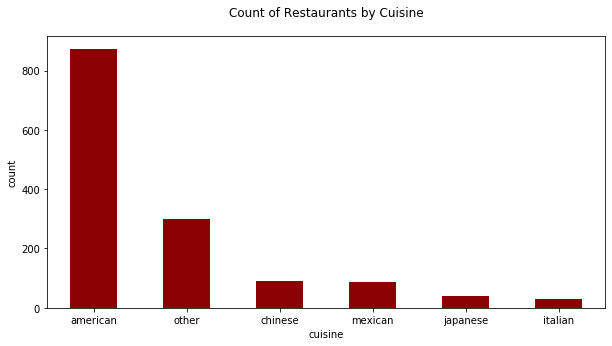

In [23]:
counts = df_bycuisine['cuisine'].value_counts()
fig = counts.plot.bar(figsize=(10,5), color='DarkRed')
fig.set_xlabel('cuisine')
fig.set_ylabel('count')
fig.set_title('Count of Restaurants by Cuisine')
plt.xticks(rotation='horizontal')
ttl = fig.title
ttl.set_position([.5, 1.05])
plt.show()

With that in mind, lets look into some of the features of the data.

In [24]:
df_bycuisine.drop(columns=['zip']).corr(method ='pearson').drop(['yelp rating', 'ethnic'], axis=0).drop(['avg. health score', 'violation count'], axis=1)

,yelp rating,ethnic
avg. health score,0.063965,-0.160651
violation count,-0.070920,0.255636


Here we can see, that there seem to be a weak correlation between our health statistics and yelp rating, but a much stronger correlation between our health statistics and whether or not a restaurant is labelled as _'ethnic'_. Lets explore this relationship more.

In [25]:
df_ethnic = df_bycuisine[df_bycuisine['ethnic'] == True]
df_american = df_bycuisine[df_bycuisine['ethnic'] == False]

m_hs_ethnic = df_ethnic['avg. health score'].mean()
m_vc_ethnic = df_ethnic['violation count'].mean()
m_hs_american = df_american['avg. health score'].mean()
m_vc_american = df_american['violation count'].mean()

mx_hs_ethnic = df_ethnic['avg. health score'].max()
mx_vc_ethnic = df_ethnic['violation count'].max()
mx_hs_american = df_american['avg. health score'].max()
mx_vc_american = df_american['violation count'].max()

mn_hs_ethnic = df_ethnic['avg. health score'].min()
mn_vc_ethnic = df_ethnic['violation count'].min()
mn_hs_american = df_american['avg. health score'].min()
mn_vc_american = df_american['violation count'].min()

r_hs_ethnic = mx_hs_ethnic - mn_hs_ethnic
r_vc_ethnic = mx_vc_ethnic - mn_vc_ethnic
r_hs_american = mx_hs_american - mn_hs_american
r_vc_american = mx_vc_american - mn_vc_american

data_hs = { 'AHS': ['ethnic', 'american'],
            'Mean': [m_hs_ethnic, m_hs_american],
            'Max': [mx_hs_ethnic, mx_hs_american],
            'Min': [mn_hs_ethnic, mn_hs_american],
            'Range': [r_hs_ethnic, r_hs_american] }

data_vc = { 'AVC': ['ethnic', 'american'],
            'Mean': [m_vc_ethnic, m_vc_american],
            'Max': [mx_vc_ethnic, mx_vc_american],
            'Min': [mn_vc_ethnic, mn_vc_american],
            'Range': [r_vc_ethnic, r_vc_american] }

df_hs = pd.DataFrame(data=data_hs).set_index(['AHS'])
df_vc = pd.DataFrame(data=data_vc).set_index(['AVC'])
df_hs

,Mean,Max,Min,Range
AHS,,,,
ethnic,94.994608,99.25,84.0,15.25
american,96.028717,100.00,76.0,24.00


In [26]:
df_vc

,Mean,Max,Min,Range
AVC,,,,
ethnic,78.659919,358,2,356
american,50.209184,216,1,215


We can see that for average health score, there is a difference in the means. Even though the min for ethnic health score is several points higher than the min for american health score, the mean american health score is still higher. This may indicate a statistically significant difference in health scores.

For violation count, this is a drastic difference in means. But its important to note that ranges for both categories are extremely high, which indicates that we may have strong outliers that can make this metric unreliable.

Moving forward we will try to determine if there is a statistical difference in health scores between restaurants labelled as ethnic and those that are not.

In [27]:
ethnic_ahs = df_ethnic['avg. health score'].values
american_ahs = df_american['avg. health score'].values

st_e, p_e = stats.normaltest(ethnic_ahs)
st_a, p_a = stats.normaltest(american_ahs)

if(p_e < alpha):
    print('Ethnic Average Health Scores normally distributed!')
if(p_a < alpha):
    print('American Average Health Scores normally distributed!')

Ethnic Average Health Scores normally distributed!
American Average Health Scores normally distributed!


Since average health scores for both categorical variables are normally distributed, we can proceed to carry out a t-test to see if the difference is statistically significant.

In [28]:
t_val, p_val = stats.ttest_ind(ethnic_ahs, american_ahs)

# Check if statistical test passes significance, using an alpha value of 0.01. This code provided.
if p_val < alpha:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is a significant difference!


There is a significant difference between restaurants that are labelled as ethnic and ones that aren't in health scores. To go further, we will want to look a bit deeper.

## Data Analysis (by Locality)
We want to see if there's a relationship between the diversity of the locality a restaurant is placed in, and its health inspection statistics.

First, we'll do some exploratory visualization to get a feel for the data. We'll plot the two metrics (average health score, and average violation count) against the diversity index.

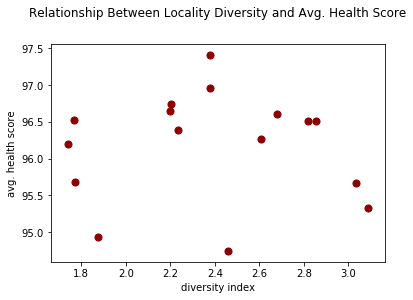

In [29]:
fig = df_bylocality.plot.scatter(x='diversity index', y='avg. health score', c='DarkRed', s=50)
fig.set_title('Relationship Between Locality Diversity and Avg. Health Score')
ttl = fig.title
ttl.set_position([.5, 1.1])
plt.show()

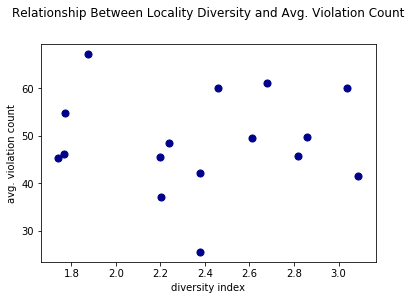

In [30]:
fig = df_bylocality.plot.scatter(x='diversity index', y='avg. violation count', c='DarkBlue', s=50)
fig.set_title('Relationship Between Locality Diversity and Avg. Violation Count')
ttl = fig.title
ttl.set_position([.5, 1.1])
plt.show()

Just from these visualizations, there doesn't seem to be enough data to conclude a strong relationship between diversity index and average violation count or average health score. We'll carry out a test of normality to see if we can continue.

In [31]:
bl_ahs = df_bylocality['avg. health score'].values
bl_avc = df_bylocality['avg. violation count'].values

st_ahs, p_ahs = stats.normaltest(bl_ahs)
st_avc, p_avc = stats.normaltest(bl_avc)

if(p_ahs < alpha):
    print('Average Health Score Normally Distributed!')
if(p_avc < alpha):
    print('Average Violation Count Normally Distributed!')

The lack of data may contribute to the reason why the data sets fail the normal test. Grouping by locality seems to overaggregate the data, which might significantly skew and statistical conclusions we may reach. Additionally, within the existing data, there seems to be low correlation between diversity index and our health statistics.

In [32]:
df_bylocality.corr(method ='pearson').drop(['avg. health score', 'avg. violation count'], axis=0).drop(columns=['diversity index'])

,avg. health score,avg. violation count
,,
diversity index,-0.022842,-0.004466


## Data Analysis (by Restaurant)
We can look instead at the dataset which assigned a diversity index to a restaurant based on the diversity index of the locality it is placed in. This data set does not suffer from the over aggregation of the `df_bylocality` data set.

First, we'll do some exploratory visualization to get a feel for the data. We'll plot the two metrics (average health score, and average violation count) against the diversity index.

In [33]:
df_byrestaurant.corr(method ='pearson').drop(['avg. health score', 'violation count'], axis=0).drop(columns=['diversity index'])

,avg. health score,violation count
diversity index,-0.001835,-0.04096


Off the bat there seems to be very weak correlation between diversity index and our health statistic. We can look at some visuals to understand this better.

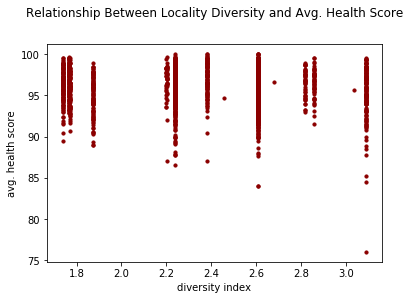

In [34]:
fig = df_byrestaurant.plot.scatter(x='diversity index', y='avg. health score', c='DarkRed', s=10)
fig.set_title('Relationship Between Locality Diversity and Avg. Health Score')
ttl = fig.title
ttl.set_position([.5, 1.1])
plt.show()

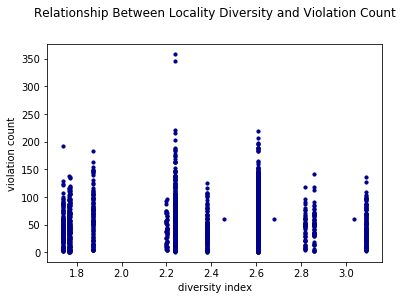

In [35]:
fig = df_byrestaurant.plot.scatter(x='diversity index', y='violation count', c='DarkBlue', s=10)
fig.set_title('Relationship Between Locality Diversity and Violation Count')
ttl = fig.title
ttl.set_position([.5, 1.1])
plt.show()

We can see in the plots above that there does not seem to be a clear visual relationship between diversity index and violation count at all, and therefore we cannot carry out linear regression to measure their relationship any further.

## Results

From this analysis, we can see there is no clear relationship between diversity index and critical health statistics. 

# Ethics & Privacy
The ethics and privacy related to data collection is depends on the data sets. On the data sets provided with the final, it is unknown how this data was collected. The uszips data set contains no personally identifying information and contains exclusively public data. The demographic data was gathered from the census all of the collected data has already been made public.

Since this question potentially relates to the equity of health inspections in major cities, it is important to consider its potential effects. If the stated hypothesis is true, the relationships defined in the research might point local governments to inequities in food safety education, the conduct of health inspection, and even the demographics of the institutions carrying out the health inspections.

I was not able to confirm my hypothesis, but the analysis did show a discrepancy in health scores given between restaurants labelled as 'ethnic' versus those that weren't. This has potential implications on the way local health inspectors carry out inspections. 

It is important to note that there was significantly more data on restaurants not labelled as 'ethnic'. This may introduce biases that may have led us to conclude that there was a larger difference in mean health scores between the two groups than there actually were.

Finally, the final data sets used to carry out the analysis contained to personally identifying information, nor information that could allow people to associate a restaurant with its health inspection records.

# Conclusion & Discussion

From this data analysis, we can reject our hypothesis that health ratings in localities with more ethnic diversity than will be lower than those with less ethnic diversity, since there is no clear linear relationship between our measure of diversity and our health statistics.

My analysis was limited, since there was not enough enough localities included in the study to carry out statistical analysis on the locality level. Since diversity information could not be generated on the individual restaurant level, our data suffered from binning which may have prevented more complete analysis.

I did find however, that there is statistically significant difference between the mean health scores for a restaurant and whether or not it is a restaurant that serves American foods. On average, restaurants that served ethnic foods were given lower health scores and on average received more health violations.

It is important to understand why this difference occurs. Is the health inspection process equitable, or is it overpenalizing restaurants that sell ethnic foods? Additionally, is there a need to overcome barriers in language and/or increase levels of food safety education? Further analysis will be needed to determine this.